In [132]:
import torch
torch.cuda.is_available()

True

In [2]:
import pandas as pd

In [3]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from wfdb import processing
import numpy as np

In [4]:
data = pd.read_csv("X_train.csv")

In [5]:
answers = pd.read_csv("y_train.csv")

In [6]:
data = (pd.merge(data ,answers, on = "Unnamed: 0"))
data['age'] = (data['age'] - data['age'].mean(axis = 0))/data['age'].std(axis = 0)

In [7]:
data = data.drop( ["Unnamed: 0"], axis = 1)

In [8]:
data.head()

,age,gender,i_0,i_1,i_2,i_3,i_4,i_5,i_6,i_7,...,v6_4991,v6_4992,v6_4993,v6_4994,v6_4995,v6_4996,v6_4997,v6_4998,v6_4999,axis_id
0,0.192357,1,-59.0,-58.0,-58.0,-58.0,-58.0,-58.0,-58.0,-58.0,...,114.0,119.0,124.0,129.0,134.0,147.0,172.0,200.0,143.0,3
1,1.399105,0,-39.0,-38.0,-38.0,-38.0,-38.0,-38.0,-38.0,-38.0,...,229.0,259.0,289.0,319.0,349.0,379.0,409.0,439.0,302.0,3
2,0.137505,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-58.0,-58.0,-58.0,-58.0,-58.0,-58.0,-38.0,-11.0,-2.0,2
3,1.344253,0,108.0,106.0,93.0,79.0,86.0,74.0,64.0,51.0,...,81.0,89.0,79.0,59.0,61.0,64.0,49.0,26.0,10.0,3
4,-1.453208,1,363.0,366.0,366.0,353.0,334.0,314.0,306.0,294.0,...,-61.0,-59.0,-86.0,-66.0,-71.0,-91.0,-84.0,-11.0,-4.0,0


In [9]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

In [10]:
signal_df = pd.read_csv("signal_data.csv", sep="#", index_col=False)

In [11]:
for column in signal_df.columns:
    signal_df[column] = signal_df[column].apply(lambda row: np.fromstring(row[1:-1], sep="  ", dtype=np.uint64))

In [12]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [13]:
from basics import *

In [14]:
class ECGDataset(FixedLengthDataset):
    def __init__(self, data, peaks, signal_length, min_start_offset = 50, max_start_offset = 300, low_cut = 5, high_cut = 20):
        super().__init__(data, peaks, signal_length, min_start_offset, max_start_offset, low_cut, high_cut)


    def __getitem__(self, idx):
        """
        Generates one sample of data.
        """
        true_idx, cut_point = self.cut_points[idx]
        label = self._get_label(true_idx)
        cut_rows = self._cut(self.filtered_data[true_idx], cut_point)
        
        return np.transpose(cut_rows), label

In [15]:
class TestECGDataset(FixedLengthDataset):
    def __init__(self, data, peaks, signal_length, min_start_offset = 50, max_start_offset = 300, low_cut = 5, high_cut = 20):
        super().__init__(data, peaks, signal_length, min_start_offset, max_start_offset, low_cut, high_cut)
               
    def _get_cuts(self):
        cut_points = [ self._get_peaks_for_signal_cuts(peaks[0])  for peaks in self.peaks]
        self.cut_points = cut_points
        
    def __len__(self):
        return len(self.data)
        
        
    def __getitem__(self, idx):
        """
        Generates one sample of data.
        """
        cut_point = np.random.choice(self.cut_points[idx])
        label = self._get_label(idx)
        cut_rows = self._cut(self.filtered_data[idx], cut_point)
        
        return np.transpose(cut_rows), label

In [16]:
dataset = TestECGDataset(data, signal_df, 3000)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [17]:
ecg_loader = DataLoader(dataset, batch_size= 2)

In [18]:
for i in ecg_loader:
    print(i[0].shape)
    print(i[1].argmax(dim=1))
    break

torch.Size([2, 3000, 12])
tensor([3, 3])


In [19]:
from torch.utils.data.sampler import SubsetRandomSampler

In [20]:
valid_size = 0.1
random_seed = 7

num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))


np.random.seed(random_seed)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_dataset = ECGDataset(data.iloc[train_idx], signal_df.iloc[train_idx], 3000)
valid_dataset = TestECGDataset(data.iloc[valid_idx], signal_df.iloc[valid_idx], 3000)

In [21]:
batchsize = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchsize, shuffle = True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batchsize, shuffle = True
)

In [22]:
import torch.nn as nn

In [160]:
class SimpleRNN(nn.Module):
    
    def __init__(self, seq_length, hidden_size=100, num_layers=1, bidirectional=False):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.seq_length = seq_length
        self.gru = nn.GRU(
            input_size = 12,
            hidden_size = hidden_size,
            num_layers = num_layers,
            bidirectional = bidirectional
        )
        self.dense = nn.Linear(hidden_size, 4)
        self.sm = nn.Softmax(dim=1)
    
    def init_hidden(self):
        k = 2 if self.bidirectional else 1
        return torch.zeros((self.num_layers * k, self.seq_length, self.hidden_size), dtype = 	torch.float)
        
    def forward(self, x, h0):
        x = x.float()
        outputs, hn = self.gru(x, h0)
        feature = outputs[:,-1,:]
        result = self.dense(feature)
        result = self.sm(result)
        return result

In [161]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [162]:
model = SimpleRNN(3000, num_layers = 3).to(device)

In [163]:
import torch.nn.functional as F

In [164]:
def validate():
    val_length = 0
    correct_answers = 0
    for i, data in enumerate(valid_loader, 0):
        # get the inputs
        (sequences, labels) = data
        sequences = sequences.to(device)
        labels = labels.to(device).argmax(dim = 1)
        h0 = model.init_hidden().to(device)

        # forward + backward + optimize
        preds = model.forward(sequences, h0)

        answer = preds.argmax(dim = 1)

        res = answer == labels 

        #print(answer)
        ##print(res)
        #print(np.sum(res)/len(answer))
        val_length += len(answer)
        correct_answers += res.sum().float()
        
    return correct_answers/val_length

In [166]:
no_of_epochs = 1000
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
total_step = len(train_loader)
for epoch in range(no_of_epochs):
    model.train()
    for i, (sequences, label) in enumerate(train_loader):
        sequences = sequences.to(device)
        label  = label.to(device).argmax(dim=1).long()
        h0 = model.init_hidden().to(device)

        # Forward Pass
        preds = model(sequences, h0)
        loss = criterion(preds, label)
        
        if (epoch%30==0 and i % 10 == 9):
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, no_of_epochs, i+1, total_step, loss.item()))

        # Backward Pass and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    if (epoch%30 == 0):
        print('Epoch [{}/{}], Score: {}' 
                   .format(epoch+1, no_of_epochs, validate()))

Epoch [1/1000], Step [10/57], Loss: 1.2629
Epoch [1/1000], Step [20/57], Loss: 1.2522
Epoch [1/1000], Step [30/57], Loss: 1.2403
Epoch [1/1000], Step [40/57], Loss: 1.1222
Epoch [1/1000], Step [50/57], Loss: 1.2074
Epoch [1/1000], Score: 0.5076923370361328
Epoch [31/1000], Step [10/57], Loss: 1.2497
Epoch [31/1000], Step [20/57], Loss: 1.2090
Epoch [31/1000], Step [30/57], Loss: 1.3005
Epoch [31/1000], Step [40/57], Loss: 1.2819
Epoch [31/1000], Step [50/57], Loss: 1.1913
Epoch [31/1000], Score: 0.4000000059604645
Epoch [61/1000], Step [10/57], Loss: 1.2904
Epoch [61/1000], Step [20/57], Loss: 1.2738
Epoch [61/1000], Step [30/57], Loss: 1.2769
Epoch [61/1000], Step [40/57], Loss: 1.1891
Epoch [61/1000], Step [50/57], Loss: 1.2258
Epoch [61/1000], Score: 0.4307692348957062
Epoch [91/1000], Step [10/57], Loss: 1.2317
Epoch [91/1000], Step [20/57], Loss: 1.2004
Epoch [91/1000], Step [30/57], Loss: 1.2062
Epoch [91/1000], Step [40/57], Loss: 1.2939
Epoch [91/1000], Step [50/57], Loss: 1.21

Epoch [901/1000], Step [40/57], Loss: 1.3206
Epoch [901/1000], Step [50/57], Loss: 1.2432
Epoch [901/1000], Score: 0.5846154093742371
Epoch [931/1000], Step [10/57], Loss: 1.3279
Epoch [931/1000], Step [20/57], Loss: 1.2055
Epoch [931/1000], Step [30/57], Loss: 1.1774
Epoch [931/1000], Step [40/57], Loss: 1.2554
Epoch [931/1000], Step [50/57], Loss: 1.0971
Epoch [931/1000], Score: 0.5230769515037537
Epoch [961/1000], Step [10/57], Loss: 1.2100
Epoch [961/1000], Step [20/57], Loss: 1.2601
Epoch [961/1000], Step [30/57], Loss: 1.1833
Epoch [961/1000], Step [40/57], Loss: 1.2744
Epoch [961/1000], Step [50/57], Loss: 1.1598
Epoch [961/1000], Score: 0.4000000059604645
Epoch [991/1000], Step [10/57], Loss: 1.1743
Epoch [991/1000], Step [20/57], Loss: 1.2200
Epoch [991/1000], Step [30/57], Loss: 1.2506
Epoch [991/1000], Step [40/57], Loss: 1.2715
Epoch [991/1000], Step [50/57], Loss: 1.1945
Epoch [991/1000], Score: 0.4307692348957062


In [153]:
model.eval()
validate()

tensor(0.4769, device='cuda:0')

(array([ 6.,  0.,  0., 11.,  0.,  0., 20.,  0.,  0., 28.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

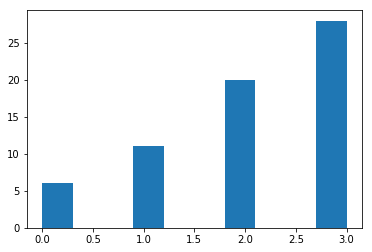

In [192]:
plt.hist(data["axis_id"].values[valid_idx])

(array([ 75.,   0.,   0.,  74.,   0.,   0., 249.,   0.,   0., 196.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

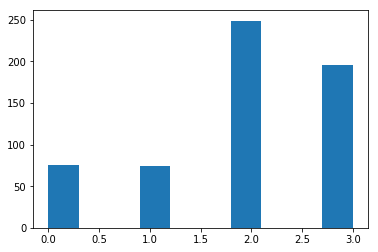

In [193]:
plt.hist(data["axis_id"].values[train_idx])